In [504]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn import tree 
from sklearn.metrics import classification_report

In [505]:
!pip install xgboost
from xgboost import XGBClassifier

In [506]:
# read county data into python with pandas 
ventura = pd.read_csv('data/daily.csv')
santabarbara = pd.read_csv('data/daily 1.csv')
sandiego = pd.read_csv('data/daily 2.csv')
sanbernardino = pd.read_csv('data/daily 3.csv')
riverside = pd.read_csv('data/daily 4.csv')
orange = pd.read_csv('data/daily 5.csv')
losangeles = pd.read_csv('data/daily 6.csv')
imperial = pd.read_csv('data/daily 7.csv')
torrey = pd.read_csv('data/daily 8.csv')

## Data Preparation 

In [507]:
# combine county data into one dataframe 
socal = pd.concat([ventura, santabarbara, sandiego, sanbernardino, riverside, orange, losangeles, imperial, torrey], axis=0)

In [508]:
socal.head()

,Stn Id,Stn Name,CIMIS Region,Date,Jul,ETo (in),qc,Precip (in),qc.1,Sol Rad (Ly/day),...,Avg Rel Hum (%),qc.9,Dew Point (F),qc.10,Avg Wind Speed (mph),qc.11,Wind Run (miles),qc.12,Avg Soil Temp (F),qc.13
0,152,Camarillo,Central Coast Valleys,1/1/2013,1,0.09,,0.0,,176.0,...,38.0,,26.1,,6.0,,144.4,,49.2,
1,152,Camarillo,Central Coast Valleys,1/2/2013,2,0.14,,0.0,,269.0,...,23.0,,19.4,,7.1,,171.5,,50.2,
2,152,Camarillo,Central Coast Valleys,1/3/2013,3,0.16,,0.0,,271.0,...,19.0,,16.8,,7.2,,172.5,,50.0,
3,152,Camarillo,Central Coast Valleys,1/4/2013,4,0.10,,0.0,,271.0,...,31.0,,24.1,,4.2,,101.8,,50.3,
4,152,Camarillo,Central Coast Valleys,1/5/2013,5,0.07,,0.0,,240.0,...,56.0,,33.5,,3.3,,79.8,,49.7,


In [509]:
socal.shape

(58446, 33)

### Feature Creation

In [510]:
# Create a new feature for CIMIS Zone 
# Use a dictionary to pair each station to its designated CIMIS zone 
socal['CIMIS Zone'] = socal['Stn Name'].map({'Camarillo':9, 'Santa Ynez':6, 'Cuyama':10, 'Otay Lake':9, 'Miramar':6, 'Victorville':17, 'Lake Arrowhead':14, 'U.C. Riverside':6, 'Temecula':6, 'Blythe NE':18, 'Irvine':6, 'Pomona':9, 'Santa Monica':2, 'Calipatria/Mulberry':18, 'Seeley':18, 'Torrey Pines':1})

### Feature Elimination

In [511]:
# elimanate unncessary features 
socal_reduced = socal.drop(['Stn Id', 'Date', 'CIMIS Region', 'Stn Name', 'qc', 'qc.1', 'qc.2', 'qc.3', 'qc.4', 'qc.5', 'qc.6', 'qc.7', 'qc.8', 'qc.9', 'qc.10', 'qc.11', 'qc.12', 'qc.13'], axis=1)

socal_reduced.head()

,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),CIMIS Zone
0,1,0.09,0.0,176.0,4.8,60.8,38.7,50.9,82.0,19.0,38.0,26.1,6.0,144.4,49.2,9
1,2,0.14,0.0,269.0,3.6,69.9,46.4,57.1,61.0,14.0,23.0,19.4,7.1,171.5,50.2,9
2,3,0.16,0.0,271.0,3.2,69.7,42.5,59.4,52.0,13.0,19.0,16.8,7.2,172.5,50.0,9
3,4,0.10,0.0,271.0,4.4,73.4,39.9,54.3,72.0,12.0,31.0,24.1,4.2,101.8,50.3,9
4,5,0.07,0.0,240.0,6.5,62.2,36.7,48.7,88.0,33.0,56.0,33.5,3.3,79.8,49.7,9


### Drop instances with null values

In [512]:
# check the size of the original dataframe 
print('Original dataframe shape:', socal_reduced.shape)

# drop all rows with missing values 
socal_reduced = socal_reduced.dropna()
print('Dataframe shape after null values are removed:', socal_reduced.shape)

Original dataframe shape: (58446, 16)
Dataframe shape after null values are removed: (53233, 16)


### Downsample to balance classes

In [513]:
# check the count of records in each class
socal_reduced['CIMIS Zone'].groupby(socal_reduced['CIMIS Zone']).count()

CIMIS Zone
1      3173
2      3490
6     17004
9     10493
10     3319
14     3547
17     3509
18     8698
Name: CIMIS Zone, dtype: int64

Classes are imbalanced.

In [514]:
# reduce all classes to the size of the minimum class count by random sampling
g = socal_reduced.groupby(socal_reduced['CIMIS Zone'])
balanced_socal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)

# confirm target feature classes are balanced
balanced_socal.groupby(balanced_df['CIMIS Zone']).count()

,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),CIMIS Zone
CIMIS Zone,,,,,,,,,,,,,,,,
1,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
2,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
6,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
9,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
10,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
14,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
17,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173
18,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173,3173


## Exploratory Data Analysis 

In [515]:
balanced_socal.head()

,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),CIMIS Zone
0,63,0.12,0.00,459.0,9.2,57.0,47.8,53.0,81.0,57.0,67.0,42.3,6.5,155.0,57.7,1
1,86,0.12,0.00,465.0,13.1,59.1,52.8,56.0,92.0,80.0,86.0,51.7,3.4,81.0,63.1,1
2,37,0.06,0.00,253.0,11.4,57.2,50.0,53.2,91.0,75.0,82.0,47.9,3.5,84.6,57.1,1
3,34,0.06,0.00,325.0,13.4,57.5,42.8,49.4,100.0,100.0,100.0,52.4,2.4,58.5,59.6,1
4,4,0.04,0.09,174.0,13.6,62.5,52.5,57.2,94.0,71.0,85.0,52.7,4.4,104.6,55.5,1


In [516]:
balanced_socal.describe()

,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),CIMIS Zone
count,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000,25384.000000
mean,183.539710,0.158962,0.023696,464.554050,11.132398,74.989048,49.932095,61.965309,80.393397,38.365427,57.444217,44.457560,4.367109,104.804460,63.289391,9.625000
std,105.825484,0.081179,0.151336,177.755584,5.281518,14.065434,12.364516,12.248865,17.968106,23.609864,22.282753,13.756524,1.839458,44.136899,11.986069,6.019618
min,1.000000,0.000000,0.000000,0.000000,0.000000,26.000000,2.500000,17.400000,0.000000,-9.000000,0.000000,-64.300000,1.000000,23.400000,31.900000,1.000000
25%,92.000000,0.090000,0.000000,319.000000,7.000000,65.300000,41.800000,54.500000,70.000000,18.000000,38.000000,35.500000,3.200000,77.400000,55.500000,5.000000
50%,184.000000,0.150000,0.000000,468.000000,10.400000,73.500000,51.200000,61.700000,86.000000,32.000000,58.000000,45.500000,4.000000,95.700000,63.300000,9.500000
75%,276.000000,0.220000,0.000000,618.000000,14.700000,83.800000,58.700000,69.100000,95.000000,58.000000,77.000000,54.900000,5.100000,121.700000,71.200000,14.750000
max,366.000000,0.490000,8.010000,1030.000000,39.600000,121.200000,91.800000,103.400000,100.000000,100.000000,100.000000,83.800000,19.400000,464.400000,99.300000,18.000000


In [517]:
# view statistical description of df features
lst = [x for x in balanced_socal.columns]
lst.remove('Jul')
lst.remove('CIMIS Zone')

for x in lst:
    print(x, '\n', balanced_socal[x].groupby(balanced_socal['CIMIS Zone']).describe(), '\n',)

ETo (in) 
              count      mean       std  min   25%   50%   75%   max
CIMIS Zone                                                         
1           3173.0  0.118235  0.051054  0.0  0.08  0.12  0.16  0.35
2           3173.0  0.138733  0.056138  0.0  0.10  0.14  0.18  0.29
6           3173.0  0.147548  0.068169  0.0  0.09  0.15  0.20  0.37
9           3173.0  0.143029  0.065062  0.0  0.09  0.14  0.20  0.31
10          3173.0  0.181179  0.089904  0.0  0.10  0.18  0.26  0.37
14          3173.0  0.151109  0.079837  0.0  0.08  0.15  0.23  0.30
17          3173.0  0.192969  0.095988  0.0  0.10  0.19  0.28  0.42
18          3173.0  0.198894  0.093093  0.0  0.12  0.20  0.28  0.49 

Precip (in) 
              count      mean       std  min  25%  50%  75%   max
CIMIS Zone                                                      
1           3173.0  0.032077  0.208481  0.0  0.0  0.0  0.0  8.01
2           3173.0  0.026013  0.155242  0.0  0.0  0.0  0.0  2.96
6           3173.0  0.028802  0.1

/var/folders/40/sx2vfnq16g7_b4jx21wm7mjh0000gn/T/ipykernel_10247/3153628017.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  balanced_socal.hist(bins=50, ax=ax)


array([[<Axes: title={'center': 'Jul'}>,
        <Axes: title={'center': 'ETo (in)'}>,
        <Axes: title={'center': 'Precip (in)'}>,
        <Axes: title={'center': 'Sol Rad (Ly/day)'}>],
       [<Axes: title={'center': 'Avg Vap Pres (mBars)'}>,
        <Axes: title={'center': 'Max Air Temp (F)'}>,
        <Axes: title={'center': 'Min Air Temp (F)'}>,
        <Axes: title={'center': 'Avg Air Temp (F)'}>],
       [<Axes: title={'center': 'Max Rel Hum (%)'}>,
        <Axes: title={'center': 'Min Rel Hum (%)'}>,
        <Axes: title={'center': 'Avg Rel Hum (%)'}>,
        <Axes: title={'center': 'Dew Point (F)'}>],
       [<Axes: title={'center': 'Avg Wind Speed (mph)'}>,
        <Axes: title={'center': 'Wind Run (miles)'}>,
        <Axes: title={'center': 'Avg Soil Temp (F)'}>,
        <Axes: title={'center': 'CIMIS Zone'}>]], dtype=object)

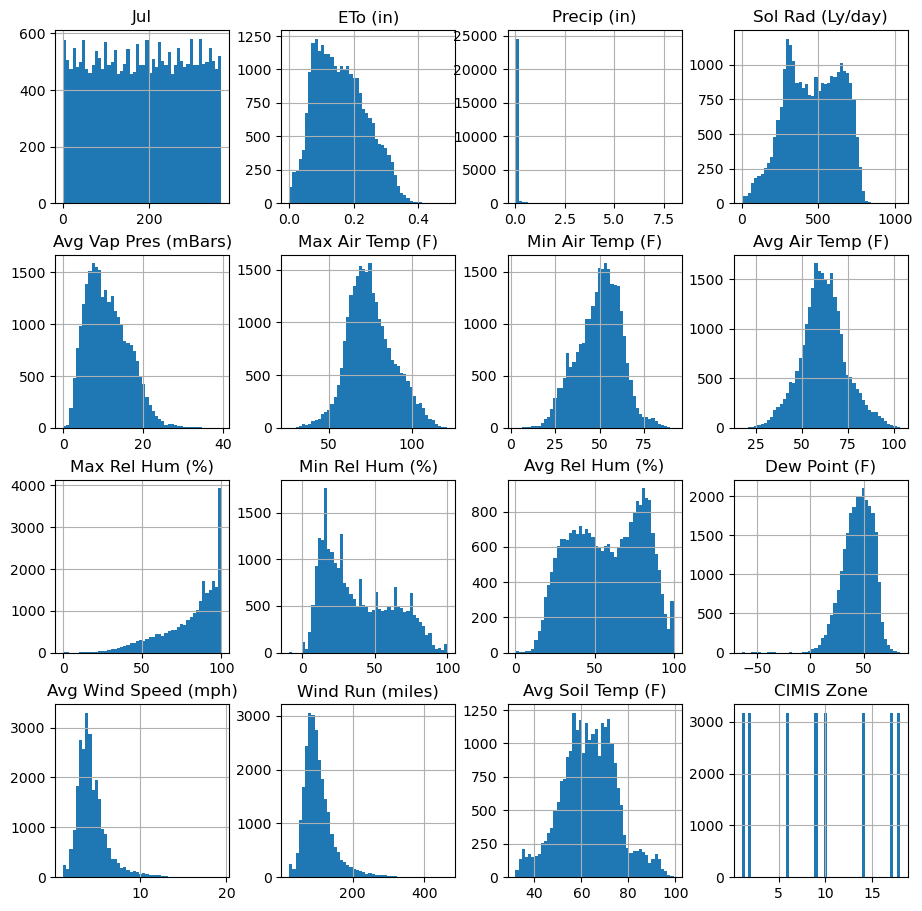

In [518]:
# generation a matrix of df feature distributions
fig, ax = plt.subplots(figsize=(11, 11))
balanced_socal.hist(bins=50, ax=ax)

In [519]:
# view the skew of each feature 
balanced_socal.skew()

Jul                     -0.008311
ETo (in)                 0.370149
Precip (in)             15.488040
Sol Rad (Ly/day)        -0.146465
Avg Vap Pres (mBars)     0.610822
Max Air Temp (F)         0.278147
Min Air Temp (F)        -0.221325
Avg Air Temp (F)         0.129137
Max Rel Hum (%)         -1.066629
Min Rel Hum (%)          0.531283
Avg Rel Hum (%)         -0.090813
Dew Point (F)           -0.586886
Avg Wind Speed (mph)     1.882322
Wind Run (miles)         1.882877
Avg Soil Temp (F)        0.036584
CIMIS Zone              -0.034657
dtype: float64

### Create a correlation matrxix

<Axes: >

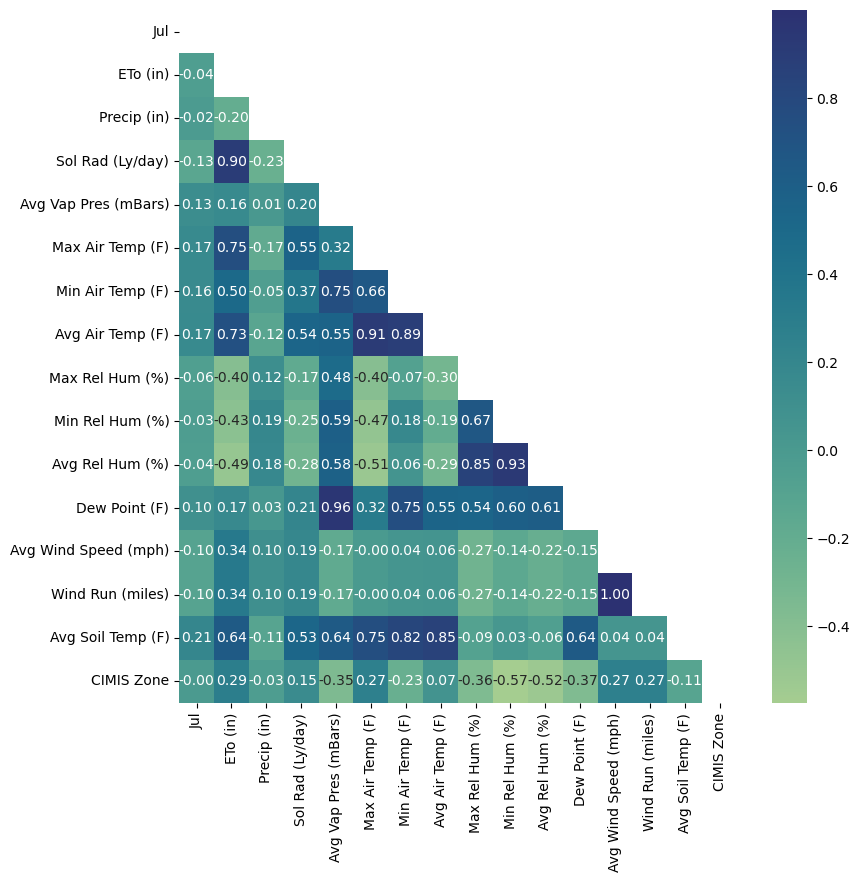

In [564]:
# create a correlation matrix
mask = np.triu(balanced_socal.corr())
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(data=balanced_socal.corr(), annot=True, fmt=".2f", ax=ax, mask=mask, cmap='crest')

In [521]:
# print a list of highly correlated features and the Pearson's correlation coeffecient 
corr = balanced_socal.corr()

corr_lst = []
for x in corr.columns:
    for i in range (0, len(corr[x])):
        c = (x, corr[x][i])
        
        if corr[x][i] == 1: 
            pass
        elif corr[x][i] > .9: 
            corr_lst.append(c) 
        elif corr[x][i] < -.9: 
            corr_lst.append(c)
        else: 
            pass
corr_lst

[('ETo (in)', 0.9017669873665868),
 ('Sol Rad (Ly/day)', 0.9017669873665868),
 ('Avg Vap Pres (mBars)', 0.9562519785972037),
 ('Max Air Temp (F)', 0.9148817584134943),
 ('Avg Air Temp (F)', 0.9148817584134943),
 ('Min Rel Hum (%)', 0.9311420911756342),
 ('Avg Rel Hum (%)', 0.9311420911756342),
 ('Dew Point (F)', 0.9562519785972037),
 ('Avg Wind Speed (mph)', 0.999877238176562),
 ('Wind Run (miles)', 0.999877238176562)]

<Axes: >

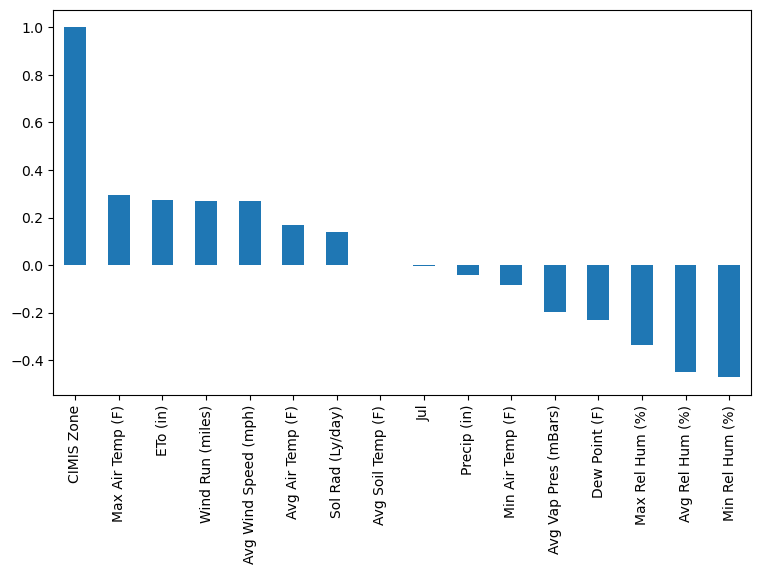

In [522]:
# plot the correlation of features with CIMIS Zone
fig, ax = plt.subplots(figsize=(9,5))
socal_reduced.corr()['CIMIS Zone'].sort_values(ascending=False).plot(kind="bar", ax=ax)

## Feature Reduction

In [523]:
# create variables for recursive feature analysis 
balanced_socal1 = balanced_socal.copy()

X = balanced_socal1
y = balanced_socal1.pop('CIMIS Zone')

In [524]:
# Use recursive feature anaylsis to reduce features 
rf = RandomForestClassifier()

rfecv = RFECV(estimator=rf, cv=10)
rfecv.fit(X,y)
rfecv.transform(X)

array([[ 63. , 459. ,  57. , ...,  42.3, 155. ,  57.7],
       [ 86. , 465. ,  59.1, ...,  51.7,  81. ,  63.1],
       [ 37. , 253. ,  57.2, ...,  47.9,  84.6,  57.1],
       ...,
       [221. , 614. , 108.9, ...,  68.1,  91.9,  96.9],
       [299. , 402. ,  80.7, ...,  49.8, 446.7,  76.9],
       [ 84. , 539. ,  88.7, ...,  45.5, 104.5,  64. ]])

In [525]:
# print the optimal number of features 
rfecv.n_features_

11

In [526]:
# create a list of features to be removed based on the results of the rfecv
drop_lst = []

for i in range(0,14):
    if rfecv.support_[i]==0.00000:
        drop_lst.append(X.columns[i])
    else:
        pass
    
drop_lst

['ETo (in)', 'Precip (in)', 'Avg Vap Pres (mBars)', 'Avg Wind Speed (mph)']

In [527]:
# create a data frame with the reduced number of features 
rb_socal = balanced_socal.drop(drop_lst, axis=1)

In [528]:
# create variables for modeling
rb_socal1 = rb_socal.copy()

X = rb_socal1
y = rb_socal1.pop('CIMIS Zone')

In [560]:
corr = rb_socal.corr()

corr_lst = []
for x in corr.columns:
    for i in range (0, len(corr[x])):
        c = (x, corr[x][i])
        
        if corr[x][i] == 1: 
            pass
        elif corr[x][i] > .9: 
            corr_lst.append(c) 
        elif corr[x][i] < -.9: 
            corr_lst.append(c)
        else: 
            pass
corr_lst

[('Max Air Temp (F)', 0.9148817584134943),
 ('Avg Air Temp (F)', 0.9148817584134943),
 ('Min Rel Hum (%)', 0.9311420911756342),
 ('Avg Rel Hum (%)', 0.9311420911756342)]

## Model Building

### Create a baseline model

In [529]:
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)

print("Accuracy:", dummy.score(X_test, y_test))

Accuracy: 0.13016073116924046


### Decision Tree Model 

In [530]:
# tune decision tree hyperparameters with GridSearch
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.4, 0.8, 1],
    'splitter': ['best', 'random'],
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}


In [550]:
# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

# train model
clf = DecisionTreeClassifier(max_depth=None, criterion='log_loss', max_features= None, splitter='best', min_samples_split= 4, min_samples_leaf= 4)
clf.fit(X_train, y_train)

# generate predicitions from model 
predictions = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.6745981720768989


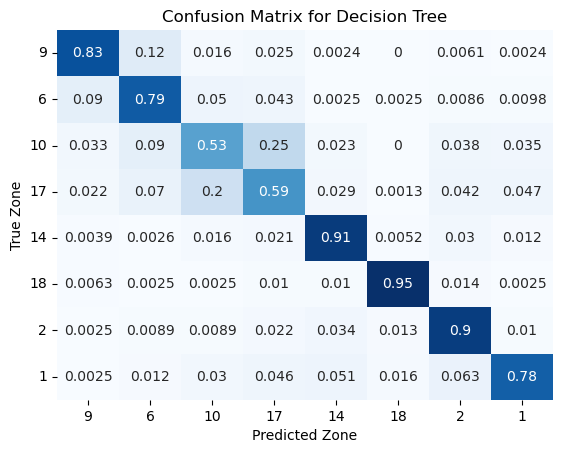

In [551]:
# create a confusion matrix counting predicted and actual values 
matrix = confusion_matrix(y_test, y_pred)

#convert counts to percentages
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(df, annot=True, cbar=None, cmap='Blues')
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted Zone')
plt.ylabel('True Zone')
plt.title('Confusion Matrix for Decision Tree')

plt.show()

In [552]:
# evaluate results of decision tree 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.73      0.75      0.74       826
           2       0.61      0.59      0.60       815
           6       0.44      0.48      0.46       793
           9       0.44      0.47      0.45       758
          10       0.78      0.80      0.79       762
          14       0.89      0.91      0.90       799
          17       0.79      0.75      0.77       788
          18       0.75      0.66      0.70       805

    accuracy                           0.67      6346
   macro avg       0.68      0.67      0.68      6346
weighted avg       0.68      0.67      0.68      6346



[Text(0.5641234639612316, 0.9821428571428571, 'Min Rel Hum (%) <= 43.5\nlog_loss = 3.0\nsamples = 19038\nvalue = [2347, 2358, 2380, 2415, 2411, 2374, 2385, 2368]'),
 Text(0.3911857669383857, 0.9464285714285714, 'Avg Soil Temp (F) <= 73.75\nlog_loss = 2.836\nsamples = 11904\nvalue = [377, 732, 1367, 1064, 2058, 1903, 2207, 2196]'),
 Text(0.21950741507358584, 0.9107142857142857, 'Min Air Temp (F) <= 43.05\nlog_loss = 2.846\nsamples = 9579\nvalue = [377, 730, 1096, 962, 1125, 1903, 2184, 1202]'),
 Text(0.050189773444294754, 0.875, 'Avg Soil Temp (F) <= 42.25\nlog_loss = 2.444\nsamples = 4178\nvalue = [15, 40, 288, 279, 872, 1359, 843, 482]'),
 Text(0.00545711898224731, 0.8392857142857143, 'Avg Air Temp (F) <= 48.95\nlog_loss = 0.679\nsamples = 643\nvalue = [0, 0, 0, 0, 13, 568, 17, 45]'),
 Text(0.0035471273384607514, 0.8035714285714286, 'Avg Soil Temp (F) <= 40.45\nlog_loss = 0.46\nsamples = 594\nvalue = [0, 0, 0, 0, 13, 554, 17, 10]'),
 Text(0.002046419618342741, 0.7678571428571429, 'Avg

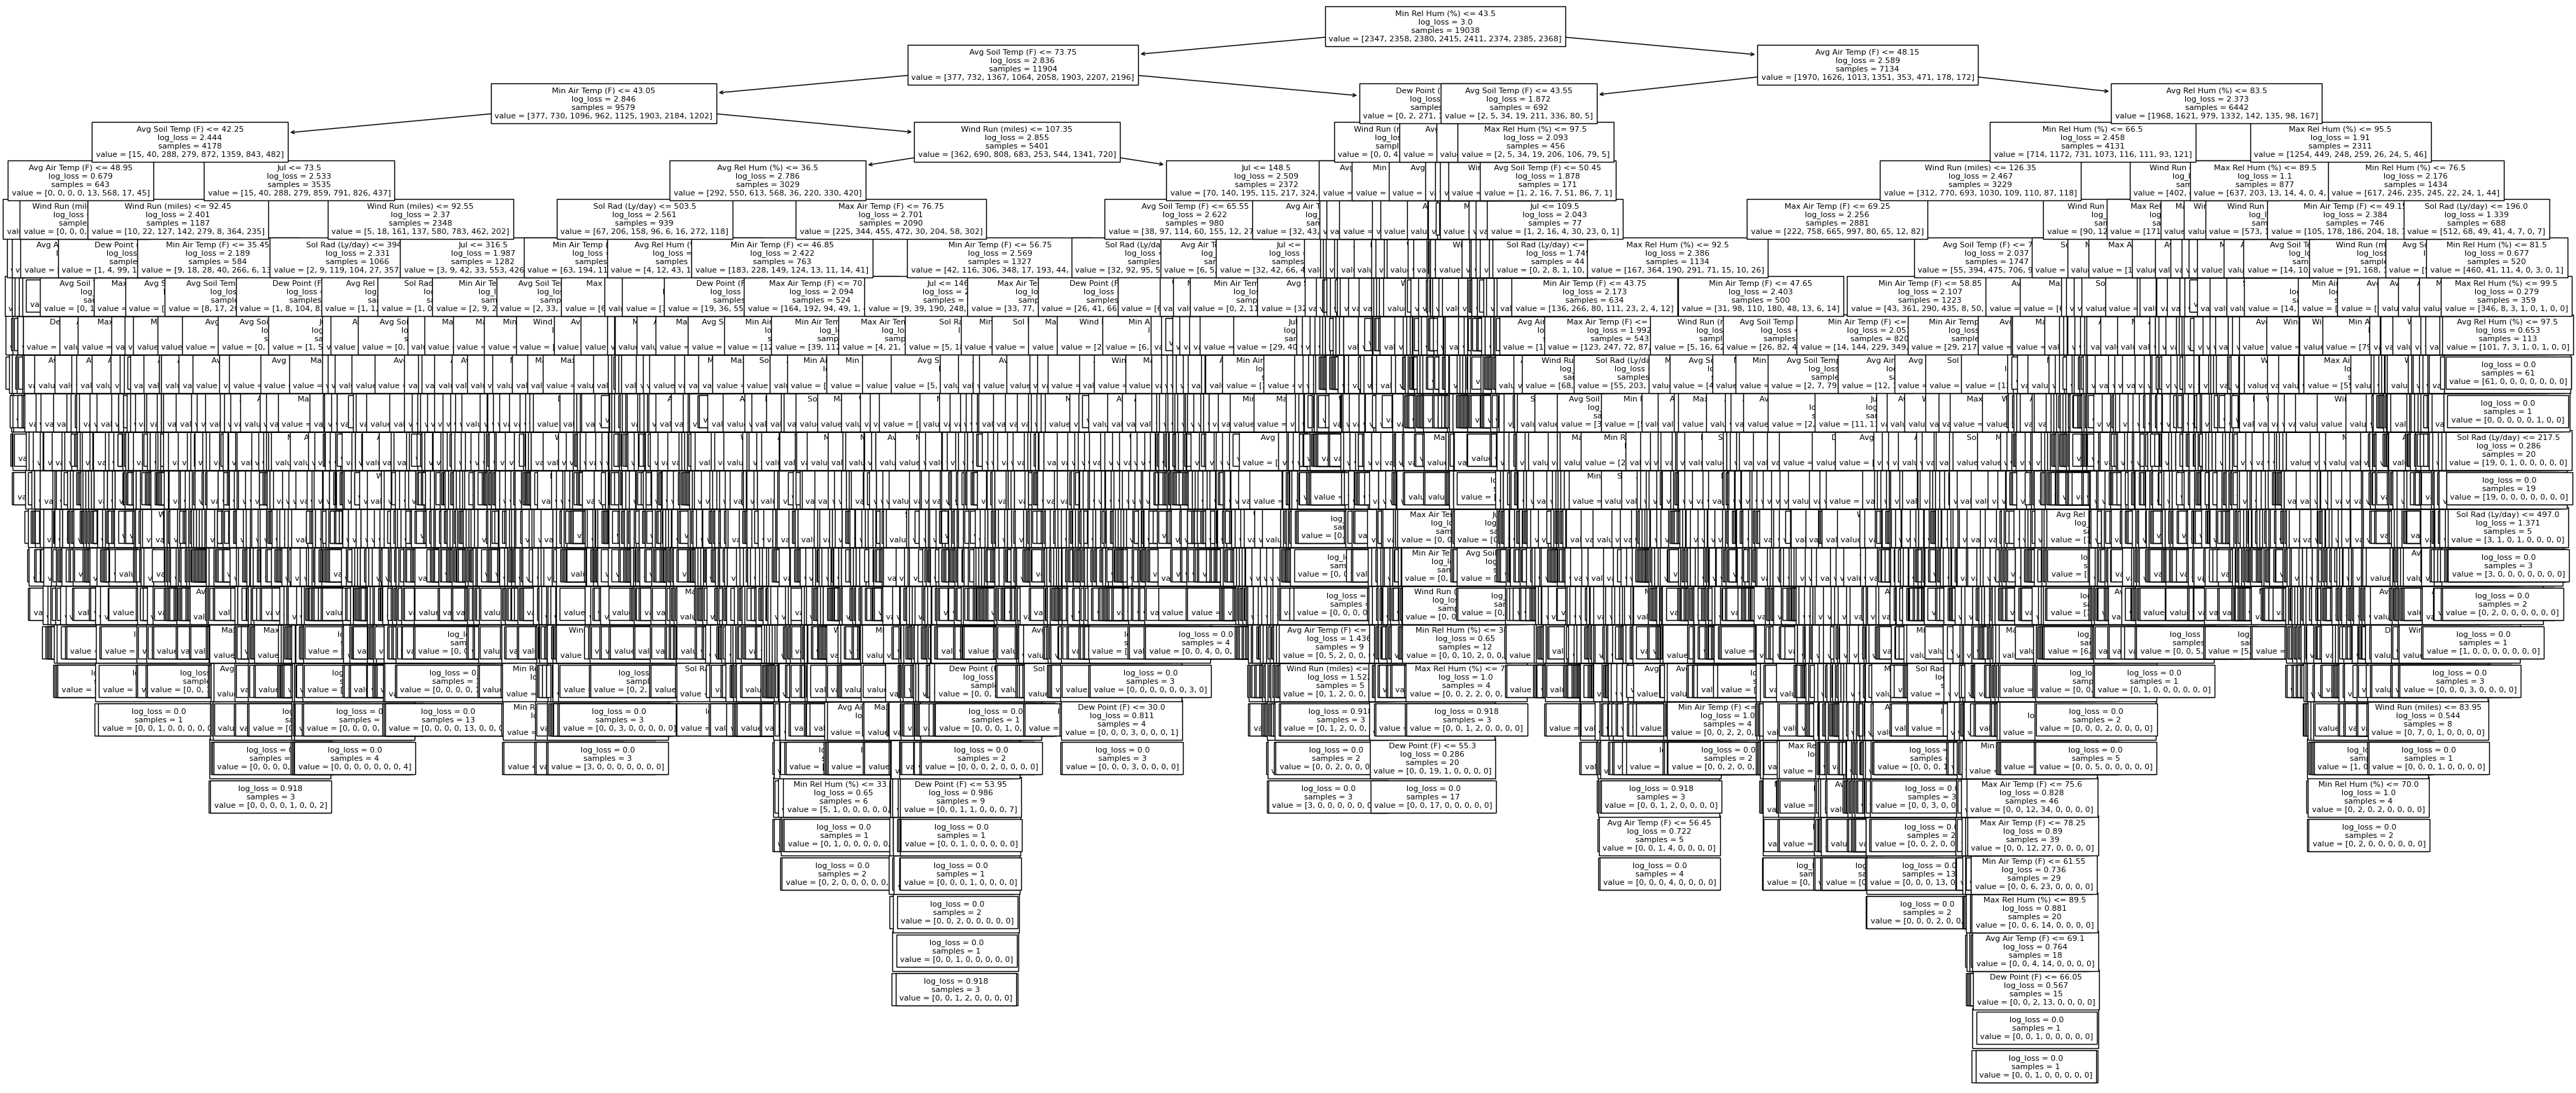

In [534]:
# plot decision tree 
fig = plt.figure(figsize=(45,20))

tree.plot_tree(clf, feature_names=['Jul', 'Sol Rad (Ly/day)', 'Max Air Temp (F)', 'Min Air Temp (F)',
       'Avg Air Temp (F)', 'Max Rel Hum (%)', 'Min Rel Hum (%)',
       'Avg Rel Hum (%)', 'Dew Point (F)', 'Wind Run (miles)',
       'Avg Soil Temp (F)'], fontsize=8)

Feature: 0, Score: 0.12538 Jul
Feature: 1, Score: 0.05177 Sol Rad (Ly/day)
Feature: 2, Score: 0.06062 Max Air Temp (F)
Feature: 3, Score: 0.14028 Min Air Temp (F)
Feature: 4, Score: 0.05871 Avg Air Temp (F)
Feature: 5, Score: 0.04344 Max Rel Hum (%)
Feature: 6, Score: 0.15503 Min Rel Hum (%)
Feature: 7, Score: 0.01854 Avg Rel Hum (%)
Feature: 8, Score: 0.04424 Dew Point (F)
Feature: 9, Score: 0.10952 Wind Run (miles)
Feature: 10, Score: 0.19245 Avg Soil Temp (F)


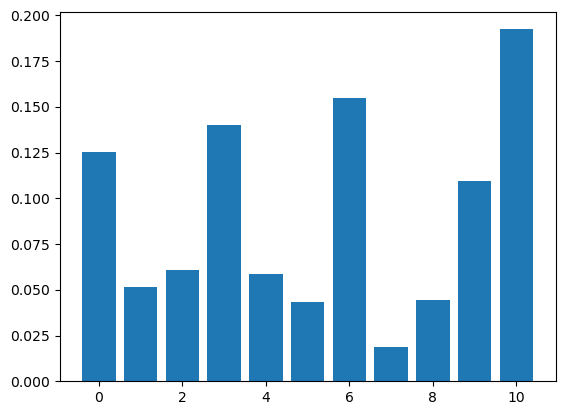

In [553]:
# determine importance of features 
importance = clf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Random Forest 

In [536]:
# Tune hyperparameters 
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'max_depth':  [None, 3, 6],
    'max_features': ['sqrt', 'log2', 0.4, 0.8, 1],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1,3, 5]
}

rfc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1
)

rfc.fit(X_train, y_train)
print(rfc.best_params_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [546]:
# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

# train model 
rf = RandomForestClassifier(min_samples_split=2,  min_samples_leaf=1, max_depth=None, criterion='entropy', max_features=0.4)
rf.fit(X_train, y_train)

# generate predictions from model 
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7860069335014183


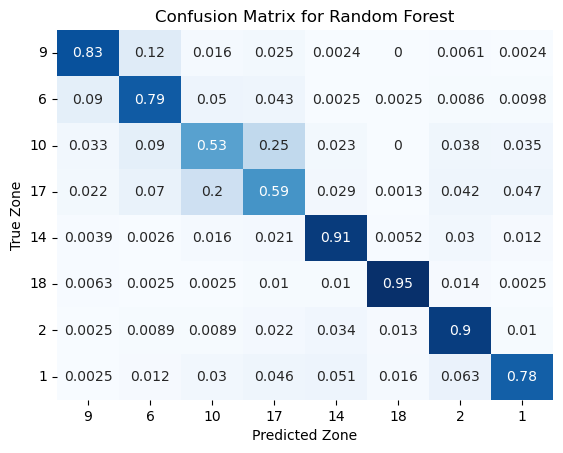

In [547]:
# create a confusion matrix counting predicted and actual values 
matrix = confusion_matrix(y_test, y_pred)

#convert counts to percentages
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(df, annot=True, cbar=None, cmap='Blues')
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted Zone')
plt.ylabel('True Zone')
plt.title('Confusion Matrix for Random Forest')

plt.show()

In [548]:
# evaluate results of random forest
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.83      0.84       826
           2       0.73      0.79      0.76       815
           6       0.63      0.53      0.57       793
           9       0.57      0.59      0.58       758
          10       0.85      0.91      0.88       762
          14       0.96      0.95      0.96       799
          17       0.82      0.90      0.86       788
          18       0.87      0.78      0.82       805

    accuracy                           0.79      6346
   macro avg       0.78      0.79      0.78      6346
weighted avg       0.78      0.79      0.78      6346



Feature: 0, Score: 0.09455 Jul
Feature: 1, Score: 0.06854 Sol Rad (Ly/day)
Feature: 2, Score: 0.08529 Max Air Temp (F)
Feature: 3, Score: 0.11626 Min Air Temp (F)
Feature: 4, Score: 0.07762 Avg Air Temp (F)
Feature: 5, Score: 0.05468 Max Rel Hum (%)
Feature: 6, Score: 0.10258 Min Rel Hum (%)
Feature: 7, Score: 0.06689 Avg Rel Hum (%)
Feature: 8, Score: 0.07419 Dew Point (F)
Feature: 9, Score: 0.10321 Wind Run (miles)
Feature: 10, Score: 0.15618 Avg Soil Temp (F)


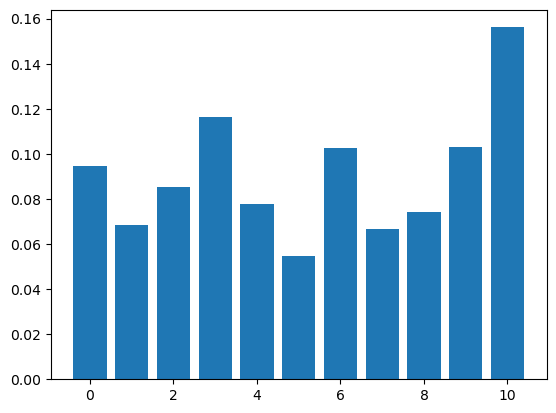

In [549]:
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## XGB

In [541]:
# tune hyperparameters with GridSearch
params = {
    'min_child_weight': range(1,3),
    'max_depth': range (4,6),
    'n_estimators': [140, 180, 220],
    'learning_rate': [0.1, .5, 1],
    'subsample': [.5, .7, .9],
    'gamma': [i/10.0 for i in range(0,5)]

}

# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

# label encode multiclass variable 
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# search for best param values
xgc = GridSearchCV(
    estimator=XGBClassifier(objective= 'multi: softmax'),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1
)

xgc.fit(X_train, y_train)
print(xgc.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
{'gamma': 0.0, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 220, 'subsample': 0.9}


In [554]:
# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23)

# label encode multiclass variable 
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# train model 
model = XGBClassifier(objective= 'multi: softmax', learning_rate=.5, max_depth=5, min_child_weight=2, n_estimators=220, subsample= 0.9, gamma=0)
model.fit(X_train, y_train)

#generate predictions 
y_pred = model.predict(X_test)

# reverse label encoding to show actual values 
y_pred = le.inverse_transform(y_pred)

# generate an accuracy score 
accuracy_score(y_test, y_pred)

0.8200441222817523

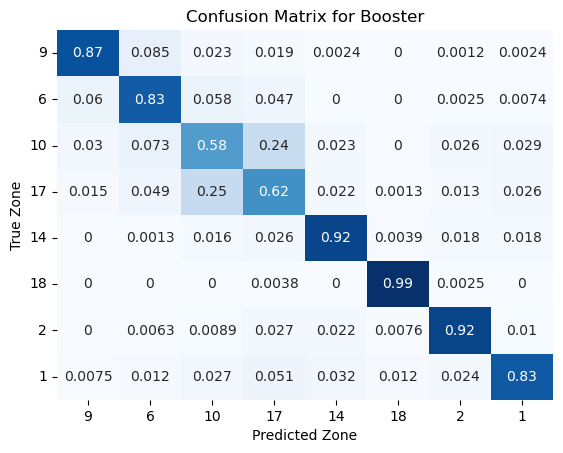

In [555]:
# create a confusion matrix counting predicted and actual values 
matrix = confusion_matrix(y_test, y_pred)

#convert counts to percentages
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(df, annot=True, cbar=None, cmap='Blues')
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted Zone')
plt.ylabel('True Zone')
plt.title('Confusion Matrix for Booster')

plt.show()

In [556]:
# evaluate results of xgboost classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.87      0.88       826
           2       0.79      0.83      0.81       815
           6       0.61      0.58      0.59       793
           9       0.59      0.62      0.60       758
          10       0.90      0.92      0.91       762
          14       0.98      0.99      0.98       799
          17       0.91      0.92      0.92       788
          18       0.90      0.83      0.87       805

    accuracy                           0.82      6346
   macro avg       0.82      0.82      0.82      6346
weighted avg       0.82      0.82      0.82      6346



Feature: 0, Score: 0.09219 Jul
Feature: 1, Score: 0.05304 Sol Rad (Ly/day)
Feature: 2, Score: 0.07518 Max Air Temp (F)
Feature: 3, Score: 0.10113 Min Air Temp (F)
Feature: 4, Score: 0.08357 Avg Air Temp (F)
Feature: 5, Score: 0.07600 Max Rel Hum (%)
Feature: 6, Score: 0.14629 Min Rel Hum (%)
Feature: 7, Score: 0.06131 Avg Rel Hum (%)
Feature: 8, Score: 0.07041 Dew Point (F)
Feature: 9, Score: 0.09346 Wind Run (miles)
Feature: 10, Score: 0.14742 Avg Soil Temp (F)


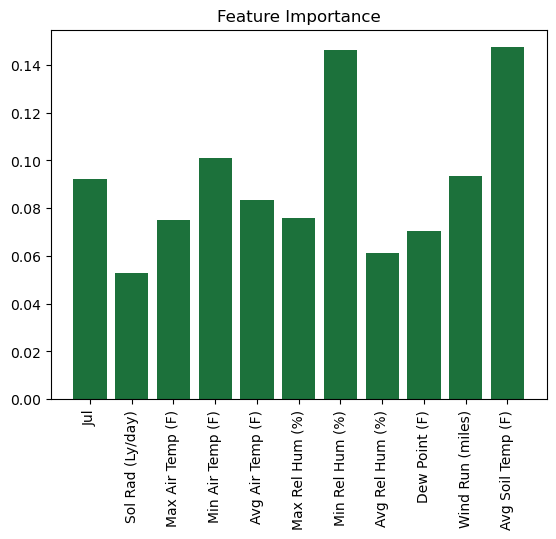

In [576]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i])
# plot feature importance
plt.bar(X.columns, importance, color='#1C713B')
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

In [565]:
importance

array([0.09218698, 0.05303735, 0.0751773 , 0.10112783, 0.08357373,
       0.07599576, 0.14629489, 0.06131218, 0.07041454, 0.0934615 ,
       0.14741793], dtype=float32)

In [566]:
X.columns

Index(['Jul', 'Sol Rad (Ly/day)', 'Max Air Temp (F)', 'Min Air Temp (F)',
       'Avg Air Temp (F)', 'Max Rel Hum (%)', 'Min Rel Hum (%)',
       'Avg Rel Hum (%)', 'Dew Point (F)', 'Wind Run (miles)',
       'Avg Soil Temp (F)'],
      dtype='object')